In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor , StackingRegressor
from xgboost import XGBRegressor
import mlflow
import mlflow.sklearn

In [2]:
df = pd.read_csv('housing.csv')

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [4]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
from sklearn.preprocessing import MinMaxScaler , LabelEncoder

lb = LabelEncoder()

df['ocean_proximity'] = lb.fit_transform(df['ocean_proximity'])

In [6]:
df['ocean_proximity'].dtype

dtype('int64')

In [7]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())

In [9]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


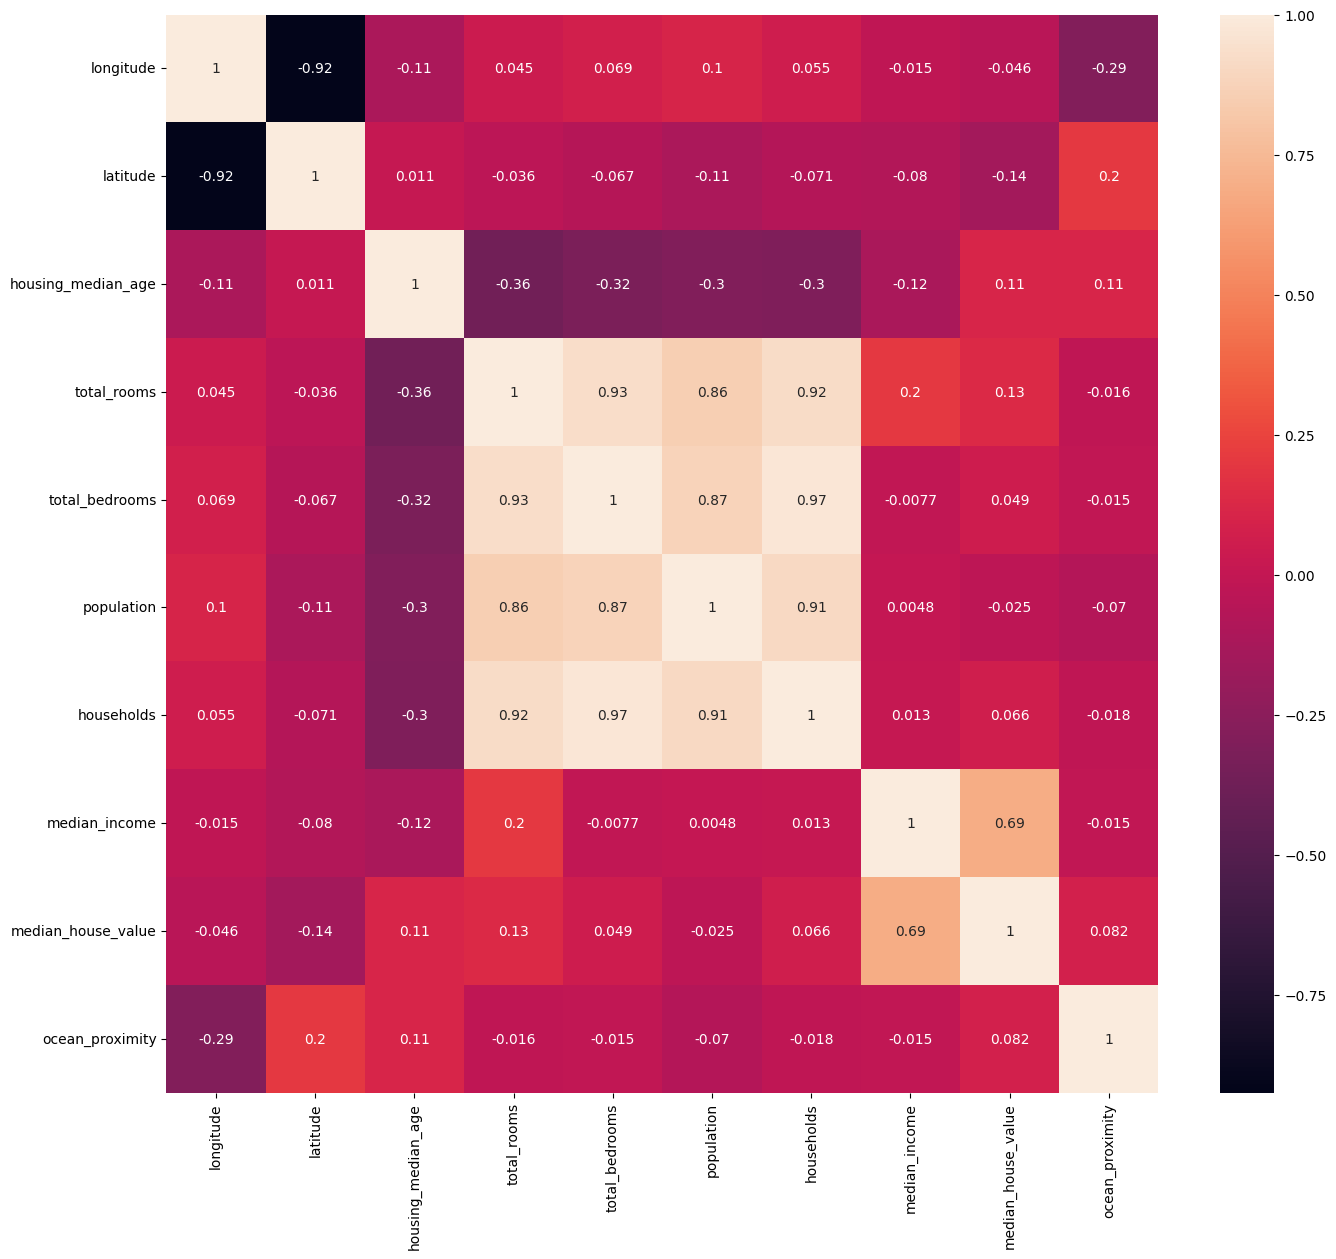

In [10]:
plt.figure(figsize = (16 , 14))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [11]:
def plot_dist(column, x_label, title, y_label='frequency'):
    plt.figure(figsize=(10, 6))
    
    # Dynamic bin size
    bin_width = (column.max() - column.min()) / 50
    bins = int((column.max() - column.min()) / bin_width)
    
    sns.histplot(column, kde=True, color='skyblue', bins=bins)
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    mean = column.mean()
    median = column.median()
    
    # Plot mean and median
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='green', label=f'Median: {median:.2f}')
    
    # Annotations
    plt.text(mean, plt.ylim()[1] * 0.9, f'Mean: {mean:.2f}', color='red', ha='center')
    plt.text(median, plt.ylim()[1] * 0.85, f'Median: {median:.2f}', color='green', ha='center')
    
    plt.legend()
    
    plt.tight_layout()
    plt.show()

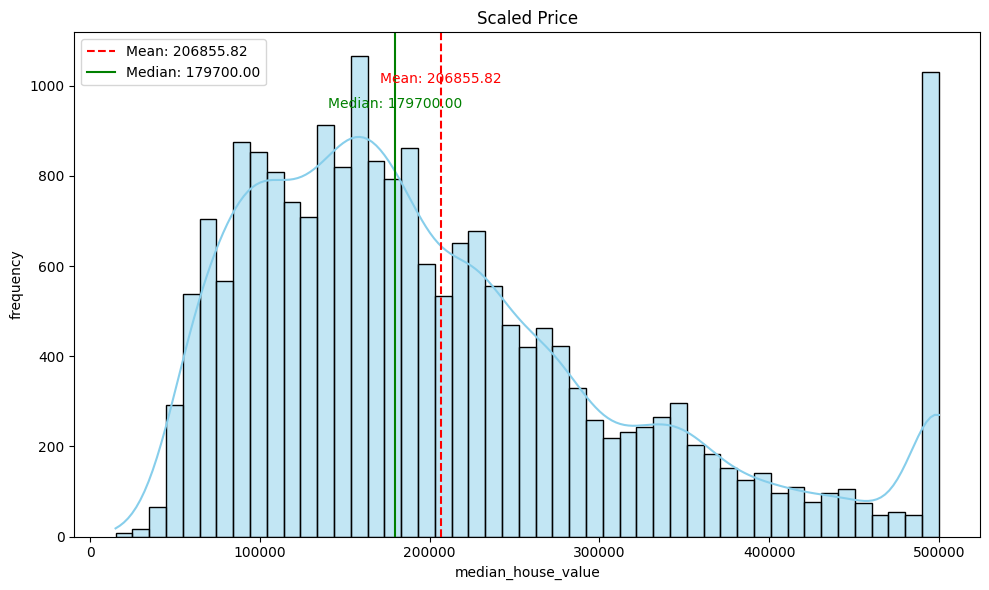

In [12]:
plot_dist(df['median_house_value'] , 'median_house_value' , 'Scaled Price')

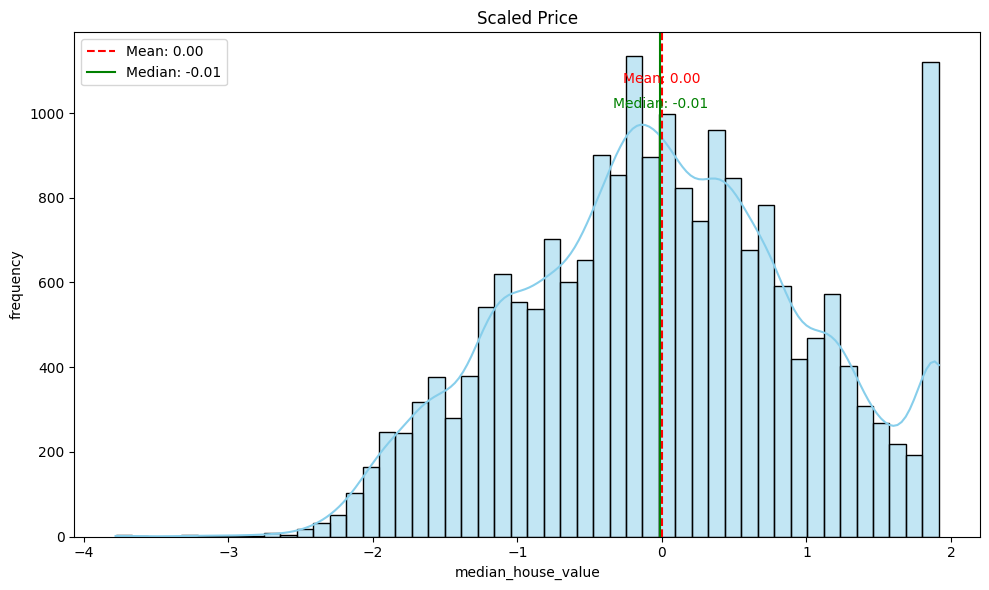

In [13]:
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(method='yeo-johnson')


df['median_house_values_scaled'] = transformer.fit_transform(df[['median_house_value']])

plot_dist(df['median_house_values_scaled'] , 'median_house_value' , 'Scaled Price')

In [14]:
df.drop(['median_house_value'] , axis = 1 , inplace = True)

In [15]:
x = df.drop(['median_house_values_scaled'] , axis = 1)
y = df['median_house_values_scaled']

In [16]:
x.shape

(20640, 9)

In [17]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 , random_state = 42)

In [18]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Random Forest

In [19]:
from sklearn.metrics import  mean_absolute_error , mean_squared_error , r2_score
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)


y_pred_rf = rf.predict(x_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

y_test_inverted = transformer.inverse_transform(np.array(y_test).reshape(-1,1))
y_pred_rf_inverted = transformer.inverse_transform(np.array(y_pred_rf).reshape(-1,1))

print("Random Forest Performance:")
print(f"MSE: {mse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R2 Score: {r2_rf:.2f}\n")

Random Forest Performance:
MSE: 0.17
MAE: 0.28
R2 Score: 0.83



C:\Users\Ahmed _ Alaa\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\Users\Ahmed _ Alaa\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


# XGBoost

In [ ]:
n_estimators=10
learning_rate=0.1
random_state=42

if mlflow.active_run():
    mlflow.end_run()

mlflow.set_experiment('XGBoost house pricing')

with mlflow.start_run():
    mlflow.log_param('Number Of Estimators' , n_estimators)
    mlflow.log_param('Learning Rate' , learning_rate)
    mlflow.log_param('Random State' , random_state)

    xgb = XGBRegressor(n_estimators = n_estimators, learning_rate = learning_rate, random_state = random_state)
    xgb.fit(x_train, y_train)
    y_pred_xgb = xgb.predict(x_test)

    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    mlflow.log_metric('Mean Squared Error' , mse_xgb)
    # print(f"Epoch {i+1}/{i} - Mean Squared Error: {mse_xgb:.4f}")

        # mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
        # mlflow.log_metric('Mean Absolute Error' , mae_xgb , step = i)
        # print(f"Epoch {i+1}/{i} - Mean Absolute Error: {mae_xgb:.4f}")

    r2_xgb = r2_score(y_test, y_pred_xgb)
    mlflow.log_metric('R Square' , r2_xgb)
    # print(f"Epoch {i+1}/{i} - R Squared: {r2_xgb:.4f}")

y_pred_xg_inverted = transformer.inverse_transform(np.array(y_pred_xgb).reshape(-1,1))

model_filename = 'XGBoost house pricing prediction2.pkl'
mlflow.sklearn.save_model(xgb , model_filename)

mlflow.log_artifact(model_filename)

print("XGBoost Performance:")
print(f"MSE: {mse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R2 Score: {r2_xgb:.2f}\n")

C:\Users\Ahmed _ Alaa\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


# Stacking

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


estimators = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=50, learning_rate=0.1, random_state=42)),
    ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))
]


final_estimator = LinearRegression()


stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5
)

stacking_regressor.fit(x_train, y_train)


y_pred_stack = stacking_regressor.predict(x_test)
mse_stack = mean_squared_error(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

y_pred_st_inverted = transformer.inverse_transform(np.array(y_pred_stack).reshape(-1,1))

print("Stacking Regressor Performance:")
print(f"MSE: {mse_stack:.2f}")
print(f"MAE: {mae_stack:.2f}")
print(f"R2 Score: {r2_stack:.2f}\n")

Stacking Regressor Performance:
MSE: 0.17
MAE: 0.28
R2 Score: 0.83



C:\Users\Ahmed _ Alaa\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


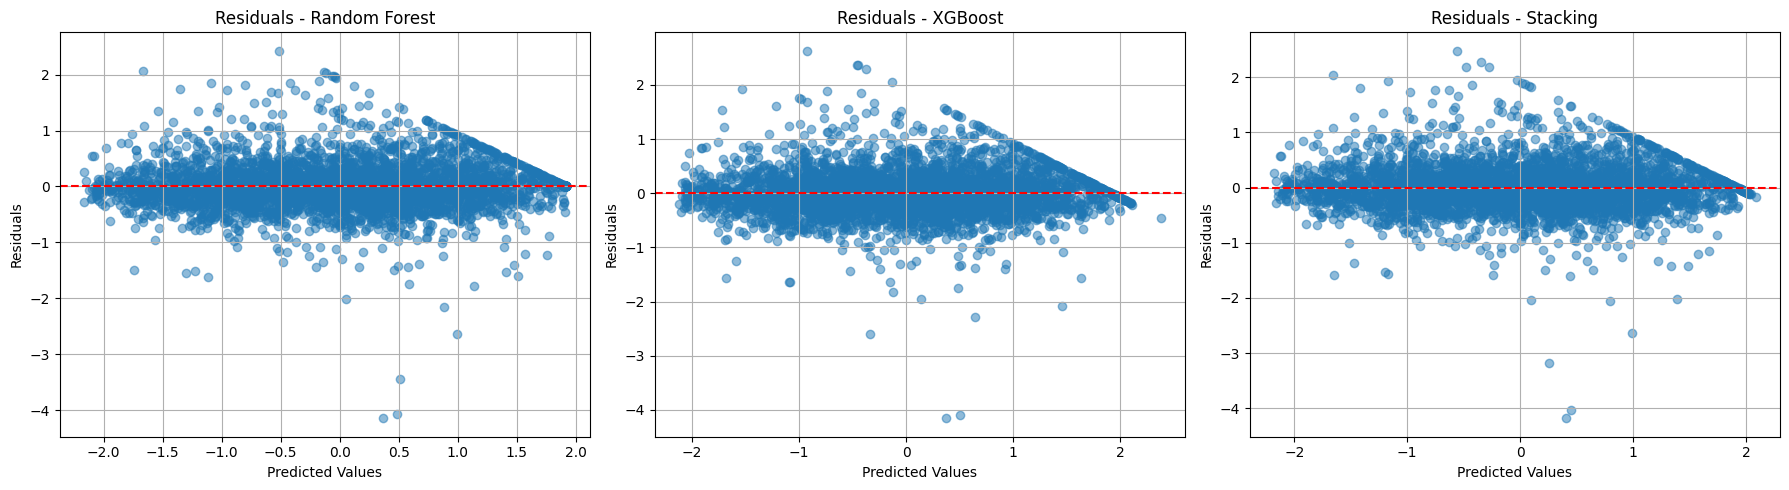

In [ ]:
def plot_residuals(ax, model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    ax.scatter(y_pred, residuals, alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'Residuals - {model_name}')
    ax.grid(True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_residuals(axes[0], rf, x_test, y_test, "Random Forest")
plot_residuals(axes[1], xgb, x_test, y_test, "XGBoost")
plot_residuals(axes[2], stacking_regressor, x_test, y_test, "Stacking")
plt.tight_layout()
plt.show()

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_train , y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
lr_predict = lr.predict(x_test)

In [22]:
mse_lr = mean_squared_error(y_test, lr_predict)
mae_lr = mean_absolute_error(y_test, lr_predict)
r2_lr = r2_score(y_test, lr_predict)

print("Linear Regression Performance:")
print(f"MSE: {mse_lr:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"R2 Score: {r2_lr:.2f}\n")

Linear Regression Performance:
MSE: 0.37
MAE: 0.46
R2 Score: 0.63

